In [179]:
import pyaudio
import wave
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [290]:
message = "hello from the other side"

# Transmitter

## Char-Freq Table

We should compute this as fast as possible and then start transmitting to the receiver. **Figure out if there are some frequencies that we should let the more common characters take.** If so, we can create a Huffman Encoding table but that's going to involve a lot of overhead so make sure it's worth it. Start transmitting as soon as this is done building and transmit asynchronously while doing following step. 

In [291]:
t = 1
samples = 100000

# Create a set with every character in file 

# Assign each possible char an integer (frequency) in a hash set

# Send sinusoids - two for each mapping because one for char and one for frequency 



# Frequency range (will need to test this)
freq_range = range(5000, 15000, 200)

chars = "abcdefghijklmnopqrstuvwxyz ."

char_freq_table = {}
projection_matrix = []

for i in range(len(chars)):
    char_freq_table[chars[i]] = freq_range[i]
    projection_matrix.append(np.sin(2 * np.pi * freq_range[i] * np.arange(t * samples) / samples))

## Encode Chars to Frequencies

Separate .txt file into chunks. Give each char in a chunk a phase and then encode frequencies according to char-freq table. **There doesn't have to be a one-to-one correspondence between sinusoid and char.** If I can fit multiple chars into one sinusoid, that's better. Only ~50 commonly used characters and thousands of frequencies. 

In [292]:
chunk_size = 3

split_message = [message[i:i+chunk_size] for i in range(0, len(message), chunk_size)]

message_freq = []

for chunk in split_message:
    message_freq.append([char_freq_table[char] for char in chunk])

print(message_freq)

[[6400, 5800, 7200], [7200, 7800, 10200], [6000, 8400, 7800], [7400, 10200, 8800], [6400, 5800, 10200], [7800, 8800, 6400], [5800, 8400, 10200], [8600, 6600, 5600], [5800]]


## Create Superposition

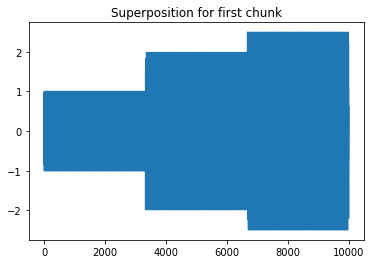

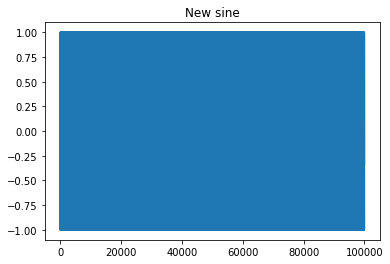

50000.00000000006


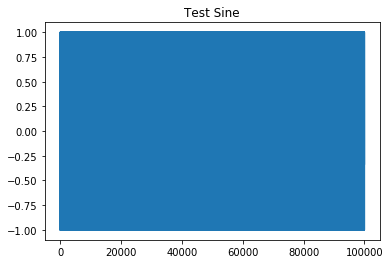

-5.020833748758946e-10


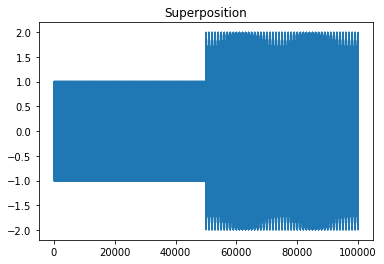

super dot test 49999.99999999979
super dot second 24999.999999999476


In [293]:
# I think we'll need to communicate length of the message and chunk size 
sigma = .1
delay = t / chunk_size 

superpositions = []

# For each chunk, generate 3 sinusoids 
for chunk in message_freq:
    # Create 3 sinusoids 
    sins = [np.sin(2 * np.pi * freq * np.arange(t * samples) / samples) for freq in chunk]
    #sins = [np.sin(np.arange(samples))]
    chunk_super = np.zeros(samples)
    # Put 3 sinusoids in superposition with delay 
    for i in range(samples):
        for j in range(len(sins)): # Use len(sins) because the group might be less than chunks
            if i >= int(j * delay * samples):
#                 print(i)
                chunk_super[i] += sins[j][i - int(j * delay)]
    #chunk_super += np.random.normal(loc=0.0, scale=sigma, size=[samples,])
    superpositions.append(chunk_super)
    
plottable_superposition = [superpositions[0][i] for i in range(samples) if i % 10 == 0]

plt.title("Superposition for first chunk")
plt.plot(plottable_superposition)
plt.show()



plt.title("New sine")
t = 1 
f = 5500
test_sin = np.sin(2 * np.pi * f * np.arange(t * samples) / samples)
plt.plot(test_sin)
plt.show()

print(np.dot(test_sin, test_sin))

sec_test_sin = np.sin(2 * np.pi * 5400 * np.arange(t * samples) / samples)
plt.title("Test Sine")
plt.plot(sec_test_sin)
plt.show()

print(np.dot(sec_test_sin, test_sin))

super_two = np.zeros(t * samples)

for i in range(len(super_two)):
    super_two[i] += test_sin[i]
    if i >= int(t * samples / 2):
        super_two[i] += sec_test_sin[i - int(t * samples / 2)]

plt.title("Superposition")
plt.plot(super_two)
plt.show()

print("super dot test", np.dot(super_two, test_sin))

print("super dot second", np.dot(super_two, sec_test_sin))

## Test Projection

In [306]:
print(np.dot(superpositions[0], superpositions[0]))

print(np.dot(superpositions[0], projection_matrix[0])) # 'a'
print(np.dot(superpositions[0], projection_matrix[7])) # 'h'

print("The next two values should be equal:")
print(np.dot(projection_matrix[4][:int(samples*delay*2)], projection_matrix[4][:int(samples*delay*2)]))
print(np.dot(superpositions[0][int(samples*delay):], projection_matrix[4][:int(samples*2*delay + 1)]))
print(np.dot(superpositions[0], np.append(np.zeros(int(samples * delay)), np.delete(projection_matrix[4], np.s_[int(samples * 2 * delay + 1):])))) # 'e'

# Okay since the last two are the same that means everything is working and the problem is that the sine waves
# aren't orthogonal to each other. I need a better concept of orthogonality to make everything work. 

99972.16349475196
11.423920534389119
49991.22866622192
The next two values should be equal:
33332.08567147904
-13033.039979806195
-13033.039979806194


In [310]:
x1 = np.sin(2 * np.pi * 5400 * np.arange(t * samples) / samples)
x2 = np.sin(2 * np.pi * 5500 * np.arange(t * samples) / samples)

np.dot(x1, x2)

print(np.max([np.dot(x1, np.sin(2 * np.pi * i * np.arange(t * samples) / samples)) for i in range(10, 100000, 100)]))

2.4041291624143923e-08


In [289]:
def projection(superpositions):
    proj_matrices = []
    for i in range(chunk_size):
        copy = np.copy(projection_matrix)
        indices_to_remove = np.s_[(samples - int(samples * delay * i)):]
        #indices_to_remove = np.s_[:int(samples * delay * i)]
        copy = np.delete(copy, indices_to_remove, 1)
        print("Reduced, ", np.shape(copy))
        zeros = np.zeros((len(chars), int(samples * delay * i)))
        print("Zeros, ", np.shape(zeros))
        copy = np.append(zeros, copy, 1)
        proj_matrices.append(copy)
        print("Combined, ", np.shape(copy))
    proj_results = [np.argmax(np.dot(superpositions[i], np.transpose(matrix))) for matrix in proj_matrices for i in range(len(superpositions))]
    #return proj_results
    return [chars[i] for i in proj_results]
    

projection(superpositions)

Reduced,  (28, 100000)
Zeros,  (28, 0)
Combined,  (28, 100000)
Reduced,  (28, 66667)
Zeros,  (28, 33333)
Combined,  (28, 100000)
Reduced,  (28, 33334)
Zeros,  (28, 66666)
Combined,  (28, 100000)


['p',
 'l',
 'f',
 'm',
 'h',
 'o',
 'e',
 's',
 'e',
 'l',
 'l',
 'f',
 ' ',
 ' ',
 'o',
 'r',
 'i',
 'g',
 'l',
 'l',
 'f',
 ' ',
 ' ',
 'o',
 'r',
 'i',
 'd']

In [195]:
test = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
new = np.zeros(3)
for i in range(3):
    for j in range(3):
        new[i] += test[j][i]
        
print(new)

[12. 15. 18.]


## Create Waveforms

In [42]:
def gen_waveforms(chunk_size, message_freq):
    # Separate message into an array of strings of length chunk_size 
    split_message = [message[i:i+chunk_size] for i in range(0, len(message), chunk_size)]
    
    # Encode each string in split_message as a superposition of frequencies 
    superpositions = [gen_sinusoids(chunk_size, [])]
    

waveforms = []
chunk_size = 1 
waveforms = gen_waveforms(chunk_size, message_freq)

In [41]:
test = [message[i:i+3] for i in range(0, len(message), 3)]
print(test)

['hel', 'lo ', 'fro', 'm t', 'he ', 'oth', 'er ', 'sid', 'e']


## Transmit 

We have to transmit according to some ECC that allows for ambient noise and sudden noise. 

In [37]:
p = pyaudio.PyAudio()
length = .1 # number of seconds to play sound 

# Generate a wave for full message (change this to generate one chunk at a time)
wavedata = ''

for freq in message_freq:
    bitrate = 16000 # number of frames per second 
    frequency = freq
    if frequency > bitrate:
        bitrate = frequency + 100 
    num_frames = int(bitrate * length)
    rest_frames = num_frames % bitrate 
    
    #generate waves 
    for j in range(num_frames):
        wavedata += chr(int(math.sin(j / ((bitrate / frequency) / math.pi)) * 127 + 128))
    for j in range(rest_frames):
        wavedata += chr(128)

print(len(wavedata))

# Now play wavedata
stream = p.open(format=p.get_format_from_width(1), channels=1, rate=bitrate, output=True)
stream.write(wavedata)
stream.stop_stream()
stream.close()
p.terminate()

80000


# Receiver

## Start Recording Audio

[Source](https://stackoverflow.com/questions/35344649/reading-input-sound-signal-using-python)

In [2]:
# CHUNK = 1024
# FORMAT = pyaudio.paInt16
# CHANNELS = 2
# RATE = 44100
# RECORD_SECONDS = 5
# WAVE_OUTPUT_FILENAME = "output.wav"

# p = pyaudio.PyAudio()

# stream = p.open(format=FORMAT,
#                 channels=CHANNELS,
#                 rate=RATE,
#                 input=True,
#                 frames_per_buffer=CHUNK)

# print("* recording")

# frames = []

# for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
#     data = stream.read(CHUNK)
#     frames.append(data)

# print("* done recording")

# stream.stop_stream()
# stream.close()
# p.terminate()

# wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
# wf.setnchannels(CHANNELS)
# wf.setsampwidth(p.get_sample_size(FORMAT))
# wf.setframerate(RATE)
# wf.writeframes(b''.join(frames))
# wf.close()


# Listen for sinusoid that means "start of char-freq table"



## Receive Char-Freq Table

We'll need some already-known way to transfer this. 

## Decoding 

Listen for chunk, receive it, then decode and write to file **asynchronously** while listening to next chunk. 

### Listen for Chunk

### Decode Chunk

Use ECC. The goal is to do a one-pass over the file so we need to have *lots* of redundancy and capability to recover from errors. 

### Write to File